#Methods Implemented

In [1]:
import numpy as np

def trunc_SVD(A,k):
  U, S, V = np.linalg.svd(A, full_matrices=False)
  U = U[:, :k]
  S = S[:k]
  V = V[:k, :]
  return U,S,V

In [2]:
import numpy as np

#Halko et. al. rSVD

def rSVD(A, k):
    """
    Simplified Randomized SVD (rSVD) algorithm without sampling

    Parameters:
    A (numpy array): matrix to be approximated
    k (int): desired rank of the approximation

    Returns:
    U (numpy array): left singular vectors
    S (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape

    # Compute random matrix Omega
    Omega = np.random.randn(n, k)

    # Compute matrix product Y = A * Omega
    Y = np.dot(A, Omega)

    # Compute QR decomposition of Y
    Q, R = np.linalg.qr(Y)

    # Compute B = Q^T * A
    B = np.dot(Q.T, A)

    # Compute SVD of B
    U_B, Sigma_B, V_B = np.linalg.svd(B, full_matrices=False)

    # U = Q * U_B
    U = np.dot(Q, U_B)

    return U, Sigma_B, V_B
    #return U@np.diag(Sigma_B)@V_B

In [3]:
import numpy as np

def power_SVD_deflation(A, k, num_iterations=5):

    A = A.copy()
    m, n = A.shape
    U = np.zeros((m, k))
    Sigma = np.zeros(k)
    V = np.zeros((n, k))

    for i in range(k):
        # Initialize random matrices
        u = np.random.randn(m)
        v = np.random.randn(n)

        for _ in range(num_iterations):
            # Power iteration
            u = np.dot(A, v)
            u /= np.linalg.norm(u)

            v = np.dot(A.T, u)
            v /= np.linalg.norm(v)

        # Store the singular value and vectors
        Sigma[i] = np.dot(u.T, np.dot(A, v))
        U[:, i] = u
        V[:, i] = v

        # Deflate the matrix
        A -= Sigma[i] * np.outer(u, v)

    return U, Sigma, V.T

In [4]:
def block_Power_SVD(A, k, num_iter):
    m, n = A.shape

    # Compute random matrix Omega
    Omega = np.random.randn(n, k)
    Q, _ = np.linalg.qr(Omega)

    # Compute Power Iteration
    for i in range(num_iter):
        if i == 0:
            block = A @ Q
        else:
            T = A.T @ Q
            block = A @ T
        Q, _ = np.linalg.qr(block)

    # Compute B = Q^T * A
    B = np.dot(Q.T, A) @ np.dot(A.T, Q)

    # Compute SVD of B
    U_B, Sigma_B, V_B = np.linalg.svd(B, full_matrices=False)

    # U = Q * U_B
    U = np.dot(Q, U_B)

    return U

In [5]:
def block_Krylov_SVD(A, k, num_iter):
    m, n = A.shape

    # Compute random matrix Omega
    Omega = np.random.randn(n, k)
    Q, _ = np.linalg.qr(Omega)

    # Compute Krylov Subspace
    K = []
    for i in range(num_iter):
        if i == 0:
            block = A @ Q
        else:
            T = A.T @ Q
            block = A @ T
        Q, _ = np.linalg.qr(block)
        K.append(Q)

    K = np.hstack(K)

    # Orthogonolize columns of K
    Q, _ = np.linalg.qr(K)

    # Compute B = Q^T * A
    B = np.dot(Q.T, A) @ np.dot(A.T, Q)

    # Compute SVD of B
    U_B, Sigma_B, V_B = np.linalg.svd(B, full_matrices=False)

    # U = Q * U_B
    U = np.dot(Q, U_B)

    #Cut to top-k
    U = U[:, :k]
    #Sigma_B = np.diag(Sigma_B[:k])
    #V_B = V_B[:k, :]

    return U

In [6]:
import math
def comp_number_iterations_power(eps, n):
    return math.ceil(math.log(n) / eps)

In [7]:
import math
def comp_number_iterations_krylov(eps, n):
    return math.ceil(math.log(n) / math.sqrt(eps))

In [8]:
def reconstruct_SVD(U,Sigma_B,V):
  return U@np.diag(Sigma_B)@V

In [9]:
def reconstruct_Block(U,A):
  return U@U.T@A

#Run on Images

##Load Image dataset

In [50]:
import os
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Set the number of images to load
num_images = 1000

# Define a transformation to convert images to grayscale
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor()])

# Load the Flowers-102 dataset
dataset = datasets.Flowers102('./data', download=True, transform=transform)

# Create a data loader to load the images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize an empty list to store the images
images = []

# Load the first 100 images
for batch_idx, (data, target) in enumerate(data_loader):
    if batch_idx >= num_images:
        break
    # Convert the image to a numpy array
    image = data.squeeze().numpy()
    # Add the image to the list
    images.append(image)

##Singe Image Analysis

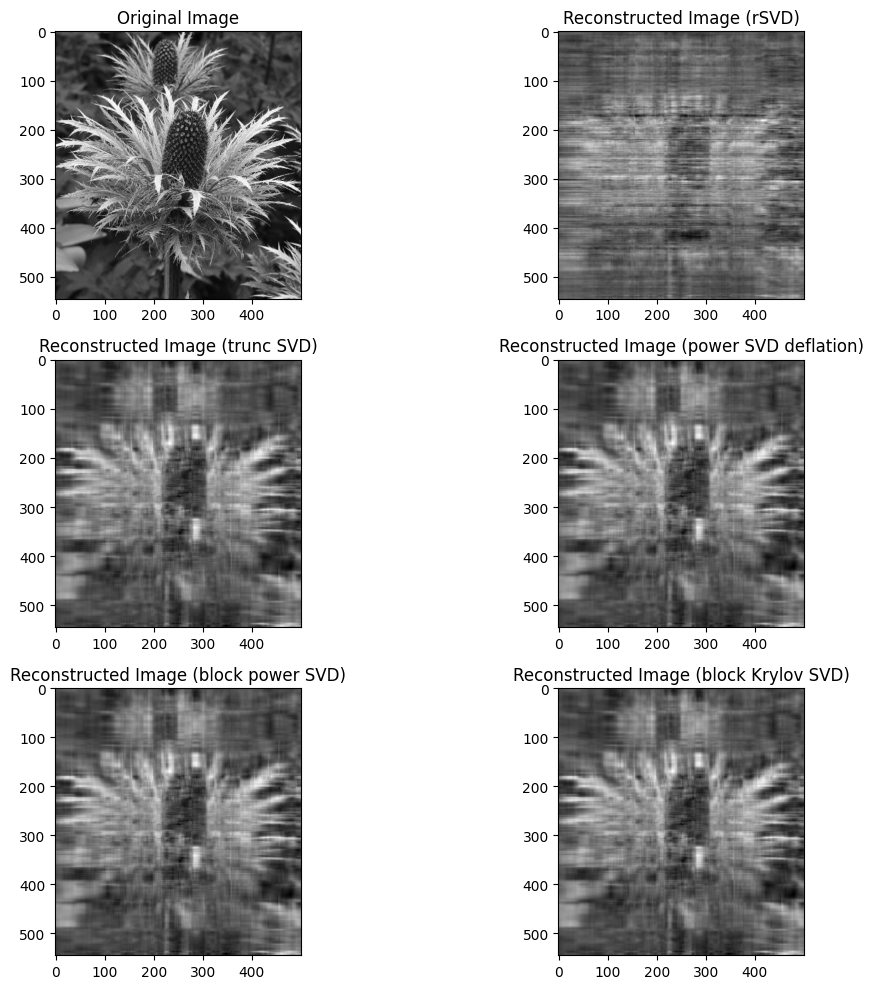

Execution time: 2.1640496253967285 seconds


In [57]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time

start_time = time.time()

# Load the image
img = Image.open('cham.jpg')
img = np.array(img)

# Convert the image to grayscale
img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

img_gray = images[2]

k = 10

# Non-iterative methods
U, S, V = rSVD(img_gray, k)
U_trunc, S_trunc, V_trunc = trunc_SVD(img_gray, k)

# Iterative methods
eps = 0.1
m, n = img_gray.shape

iter_power = comp_number_iterations_power(eps, n)
iter_krylov = comp_number_iterations_krylov(eps, n)

U_block_power = block_Power_SVD(img_gray, k, iter_power)
U_block_krylov = block_Krylov_SVD(img_gray, k, iter_krylov)
U_power, S_power, V_power = power_SVD_deflation(img_gray, k, iter_power)

# Reconstruct the image using the top k singular values and vectors
img_original = img_gray

img_reconstructed_rsvd = reconstruct_SVD(U, S, V)
img_reconstructed_trunc = reconstruct_SVD(U_trunc, S_trunc, V_trunc)
img_reconstructed_power = reconstruct_SVD(U_power, S_power, V_power)
img_reconstructed_block_power = reconstruct_Block(U_block_power, img_gray)
img_reconstructed_block_krylov = reconstruct_Block(U_block_krylov, img_gray)

# Display the original and reconstructed images
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Original Image')

plt.subplot(3, 2, 2)
plt.imshow(img_reconstructed_rsvd, cmap='gray')
plt.title('Reconstructed Image (rSVD)')

plt.subplot(3, 2, 3)
plt.imshow(img_reconstructed_trunc, cmap='gray')
plt.title('Reconstructed Image (trunc SVD)')

plt.subplot(3, 2, 4)
plt.imshow(img_reconstructed_power, cmap='gray')
plt.title('Reconstructed Image (power SVD deflation)')

plt.subplot(3, 2, 5)
plt.imshow(img_reconstructed_block_power, cmap='gray')
plt.title('Reconstructed Image (block power SVD)')

plt.subplot(3, 2, 6)
plt.imshow(img_reconstructed_block_krylov, cmap='gray')
plt.title('Reconstructed Image (block Krylov SVD)')

plt.tight_layout()
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [43]:
from skimage.metrics import structural_similarity as ssim

ssim_rsvd = ssim(img_original, img_reconstructed_rsvd, data_range=img_original.max() - img_original.min())
ssim_trunc = ssim(img_original, img_reconstructed_trunc, data_range=img_original.max() - img_original.min())
ssim_power = ssim(img_original, img_reconstructed_power, data_range=img_original.max() - img_original.min())
ssim_block_power = ssim(img_original, img_reconstructed_block_power, data_range=img_original.max() - img_original.min())
ssim_block_krylov = ssim(img_original, img_reconstructed_block_krylov, data_range=img_original.max() - img_original.min())

print("SSIM scores:")
print(f"rSVD: {ssim_rsvd}")
print(f"trunc SVD: {ssim_trunc}")
print(f"power SVD deflation: {ssim_power}")
print(f"block power SVD: {ssim_block_power}")
print(f"block Krylov SVD: {ssim_block_krylov}")

SSIM scores:
rSVD: 0.7112942978948645
trunc SVD: 0.8786070425739781
power SVD deflation: 0.8786055617532603
block power SVD: 0.8786264620084852
block Krylov SVD: 0.8786070357605948


In [49]:
frobenius_norm_rsvd = np.linalg.norm(img_original - img_reconstructed_rsvd, 'fro')
frobenius_norm_trunc = np.linalg.norm(img_original - img_reconstructed_trunc, 'fro')
frobenius_norm_power = np.linalg.norm(img_original - img_reconstructed_power, 'fro')
frobenius_norm_block_power = np.linalg.norm(img_original - img_reconstructed_block_power, 'fro')
frobenius_norm_block_krylov = np.linalg.norm(img_original - img_reconstructed_block_krylov, 'fro')

spectral_norm_rsvd = np.linalg.norm(img_original - img_reconstructed_rsvd, 2)
spectral_norm_trunc = np.linalg.norm(img_original - img_reconstructed_trunc, 2)
spectral_norm_power = np.linalg.norm(img_original - img_reconstructed_power, 2)
spectral_norm_block_power = np.linalg.norm(img_original - img_reconstructed_block_power, 2)
spectral_norm_block_krylov = np.linalg.norm(img_original - img_reconstructed_block_krylov, 2)

print("Frobenius norm errors:")
print(f"rSVD: {frobenius_norm_rsvd}")
print(f"trunc SVD: {frobenius_norm_trunc}")
print(f"power SVD deflation: {frobenius_norm_power}")
print(f"block power SVD: {frobenius_norm_block_power}")
print(f"block Krylov SVD: {frobenius_norm_block_krylov}")
print(" ")
print("Spectral norm errors:")
print(f"rSVD: {spectral_norm_rsvd}")
print(f"trunc SVD: {spectral_norm_trunc}")
print(f"power SVD deflation: {spectral_norm_power}")
print(f"block power SVD: {spectral_norm_block_power}")
print(f"block Krylov SVD: {spectral_norm_block_krylov}")


Frobenius norm errors:
rSVD: 26.486903120182763
trunc SVD: 14.652018547058105
power SVD deflation: 14.652025964179884
block power SVD: 14.652071252756125
block Krylov SVD: 14.652025460204054
 
Spectral norm errors:
rSVD: 8.84096092673863
trunc SVD: 3.053412437438965
power SVD deflation: 3.0534149215074593
block power SVD: 3.053632272606449
block Krylov SVD: 3.05341254696214


##Multiple images Analysis

In [51]:
def reconstruct_and_measure(img, k, eps):
    U, S, V = rSVD(img, k)
    U_trunc, S_trunc, V_trunc = trunc_SVD(img, k)

    m, n = img.shape

    iter_power = comp_number_iterations_power(eps, n)
    iter_krylov = comp_number_iterations_krylov(eps, n)

    U_power, S_power, V_power = power_SVD_deflation(img, k, iter_power)
    U_block_power = block_Power_SVD(img, k, iter_power)
    U_block_krylov = block_Krylov_SVD(img, k, iter_krylov)

    # Reconstruct the image
    img_reconstructed_rsvd = reconstruct_SVD(U, S, V)
    img_reconstructed_trunc = reconstruct_SVD(U_trunc, S_trunc, V_trunc)
    img_reconstructed_power = reconstruct_SVD(U_power, S_power, V_power)
    img_reconstructed_block_power = reconstruct_Block(U_block_power, img)
    img_reconstructed_block_krylov = reconstruct_Block(U_block_krylov, img)

    # SSIM, relative Frobenius norm error, relative spectral norm error
    ssim_rsvd = ssim(img, img_reconstructed_rsvd, data_range=img.max() - img.min())
    ssim_trunc = ssim(img, img_reconstructed_trunc, data_range=img.max() - img.min())
    ssim_power = ssim(img, img_reconstructed_power, data_range=img.max() - img.min())
    ssim_block_power = ssim(img, img_reconstructed_block_power, data_range=img.max() - img.min())
    ssim_block_krylov = ssim(img, img_reconstructed_block_krylov, data_range=img.max() - img.min())

    frobenius_norm_rsvd = np.linalg.norm(img - img_reconstructed_rsvd, 'fro') / np.linalg.norm(img, 'fro')
    frobenius_norm_trunc = np.linalg.norm(img - img_reconstructed_trunc, 'fro') / np.linalg.norm(img, 'fro')
    frobenius_norm_power = np.linalg.norm(img - img_reconstructed_power, 'fro') / np.linalg.norm(img, 'fro')
    frobenius_norm_block_power = np.linalg.norm(img - img_reconstructed_block_power, 'fro') / np.linalg.norm(img, 'fro')
    frobenius_norm_block_krylov = np.linalg.norm(img - img_reconstructed_block_krylov, 'fro') / np.linalg.norm(img, 'fro')

    spectral_norm_rsvd = np.linalg.norm(img - img_reconstructed_rsvd, 2) / np.linalg.norm(img, 2)
    spectral_norm_trunc = np.linalg.norm(img - img_reconstructed_trunc, 2) / np.linalg.norm(img, 2)
    spectral_norm_power = np.linalg.norm(img - img_reconstructed_power, 2) / np.linalg.norm(img, 2)
    spectral_norm_block_power = np.linalg.norm(img - img_reconstructed_block_power, 2) / np.linalg.norm(img, 2)
    spectral_norm_block_krylov = np.linalg.norm(img - img_reconstructed_block_krylov, 2) / np.linalg.norm(img, 2)

    return ssim_rsvd, ssim_trunc, ssim_power, ssim_block_power, ssim_block_krylov, \
           frobenius_norm_rsvd, frobenius_norm_trunc, frobenius_norm_power, frobenius_norm_block_power, frobenius_norm_block_krylov, \
           spectral_norm_rsvd, spectral_norm_trunc, spectral_norm_power, spectral_norm_block_power, spectral_norm_block_krylov

def time_method(func, *args):
    import time
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time


In [53]:
k = 50
eps = 0.5

from tabulate import tabulate
ssim_rsvd_all = []
ssim_trunc_all = []
ssim_power_all = []
ssim_block_power_all = []
ssim_block_krylov_all = []

frobenius_norm_rsvd_all = []
frobenius_norm_trunc_all = []
frobenius_norm_power_all = []
frobenius_norm_block_power_all = []
frobenius_norm_block_krylov_all = []

spectral_norm_rsvd_all = []
spectral_norm_trunc_all = []
spectral_norm_power_all = []
spectral_norm_block_power_all = []
spectral_norm_block_krylov_all = []

time_rsvd_all = []
time_trunc_all = []
time_power_all = []
time_block_power_all = []
time_block_krylov_all = []


counter = 0
for img in images:
    ssim_rsvd, ssim_trunc, ssim_power, ssim_block_power, ssim_block_krylov, \
    frobenius_norm_rsvd, frobenius_norm_trunc, frobenius_norm_power, frobenius_norm_block_power, frobenius_norm_block_krylov, \
    spectral_norm_rsvd, spectral_norm_trunc, spectral_norm_power, spectral_norm_block_power, spectral_norm_block_krylov = reconstruct_and_measure(img, k, eps)

    ssim_rsvd_all.append(ssim_rsvd)
    ssim_trunc_all.append(ssim_trunc)
    ssim_power_all.append(ssim_power)
    ssim_block_power_all.append(ssim_block_power)
    ssim_block_krylov_all.append(ssim_block_krylov)

    frobenius_norm_rsvd_all.append(frobenius_norm_rsvd)
    frobenius_norm_trunc_all.append(frobenius_norm_trunc)
    frobenius_norm_power_all.append(frobenius_norm_power)
    frobenius_norm_block_power_all.append(frobenius_norm_block_power)
    frobenius_norm_block_krylov_all.append(frobenius_norm_block_krylov)

    spectral_norm_rsvd_all.append(spectral_norm_rsvd)
    spectral_norm_trunc_all.append(spectral_norm_trunc)
    spectral_norm_power_all.append(spectral_norm_power)
    spectral_norm_block_power_all.append(spectral_norm_block_power)
    spectral_norm_block_krylov_all.append(spectral_norm_block_krylov)

    time_rsvd_all.append(time_method(rSVD, img, k))
    time_trunc_all.append(time_method(trunc_SVD, img, k))
    time_power_all.append(time_method(power_SVD_deflation, img, k))
    time_block_power_all.append(time_method(block_Power_SVD, img, k, 5))
    time_block_krylov_all.append(time_method(block_Krylov_SVD, img, k, 5))

    counter+=1

    if(counter % 100 == 0):
      print(counter, " processed")

avg_ssim_rsvd = np.mean(ssim_rsvd_all)
avg_ssim_trunc = np.mean(ssim_trunc_all)
avg_ssim_power = np.mean(ssim_power_all)
avg_ssim_block_power = np.mean(ssim_block_power_all)
avg_ssim_block_krylov = np.mean(ssim_block_krylov_all)

avg_frobenius_norm_rsvd = np.mean(frobenius_norm_rsvd_all)
avg_frobenius_norm_trunc = np.mean(frobenius_norm_trunc_all)
avg_frobenius_norm_power = np.mean(frobenius_norm_power_all)
avg_frobenius_norm_block_power = np.mean(frobenius_norm_block_power_all)
avg_frobenius_norm_block_krylov = np.mean(frobenius_norm_block_krylov_all)

avg_spectral_norm_rsvd = np.mean(spectral_norm_rsvd_all)
avg_spectral_norm_trunc = np.mean(spectral_norm_trunc_all)
avg_spectral_norm_power = np.mean(spectral_norm_power_all)
avg_spectral_norm_block_power = np.mean(spectral_norm_block_power_all)
avg_spectral_norm_block_krylov = np.mean(spectral_norm_block_krylov_all)

avg_time_rsvd = np.mean(time_rsvd_all)
avg_time_trunc = np.mean(time_trunc_all)
avg_time_power = np.mean(time_power_all)
avg_time_block_power = np.mean(time_block_power_all)
avg_time_block_krylov = np.mean(time_block_krylov_all)

print(tabulate([
    ["SSIM", avg_ssim_rsvd, avg_ssim_trunc, avg_ssim_power, avg_ssim_block_power, avg_ssim_block_krylov],
    ["Relative Frobenius norm error", avg_frobenius_norm_rsvd, avg_frobenius_norm_trunc, avg_frobenius_norm_power, avg_frobenius_norm_block_power, avg_frobenius_norm_block_krylov],
    ["Relative Spectral norm error", avg_spectral_norm_rsvd, avg_spectral_norm_trunc, avg_spectral_norm_power, avg_spectral_norm_block_power, avg_spectral_norm_block_krylov],
    ["Time (s)", avg_time_rsvd, avg_time_trunc, avg_time_power, avg_time_block_power, avg_time_block_krylov],
], headers=["Metric", "rSVD", "trunc_SVD", "power_SVD", "block_power_SVD", "block_Krylov_SVD"]))


100  processed
200  processed
300  processed
400  processed
500  processed
600  processed
700  processed
800  processed
900  processed
1000  processed
Metric                               rSVD    trunc_SVD    power_SVD    block_power_SVD    block_Krylov_SVD
-----------------------------  ----------  -----------  -----------  -----------------  ------------------
SSIM                           0.688497      0.847862     0.84759            0.847542            0.847862
Relative Frobenius norm error  0.102122      0.0619878    0.0620491          0.0620594           0.0619878
Relative Spectral norm error   0.0315171     0.0121688    0.0123818          0.0124058           0.0121688
Time (s)                       0.00913211    0.0844845    0.446623           0.0247392           0.0533206


##Large Matrix Dataset

In [10]:
!unzip lastfm_asia.zip

Archive:  lastfm_asia.zip
   creating: lasftm_asia/
  inflating: lasftm_asia/lastfm_asia_edges.csv  
  inflating: lasftm_asia/lastfm_asia_target.csv  
  inflating: lasftm_asia/lastfm_asia_features.json  
  inflating: lasftm_asia/README.txt  


In [74]:
import pandas as pd
import numpy as np

# Load the edge list
edges = pd.read_csv('lasftm_asia/lastfm_asia_edges.csv')

# Get the unique node IDs
nodes = np.concatenate((edges['node_1'].unique(), edges['node_2'].unique()))
node_ids = np.unique(nodes)

# Create a dictionary to map node IDs to indices
node_dict = {node_id: i for i, node_id in enumerate(node_ids)}

# Create the adjacency matrix
adj_matrix = np.zeros((len(node_ids), len(node_ids)))

# Populate the adjacency matrix
for index, row in edges.iterrows():
    source_idx = node_dict[row['node_1']]
    target_idx = node_dict[row['node_2']]
    adj_matrix[source_idx, target_idx] = 1
    adj_matrix[target_idx, source_idx] = 1  # Since the graph is undirected

print(adj_matrix.shape)


(7624, 7624)


In [72]:
import numpy as np
import time
import psutil
import os
from tabulate import tabulate

k = 10

# Initialize metrics
frobenius_norm_rsvd = 0
frobenius_norm_trunc = 0
frobenius_norm_power = 0
frobenius_norm_block_power = 0
frobenius_norm_block_krylov = 0

spectral_norm_rsvd = 0
spectral_norm_trunc = 0
spectral_norm_power = 0
spectral_norm_block_power = 0
spectral_norm_block_krylov = 0

ram_used_rsvd = 0
ram_used_trunc = 0
ram_used_power = 0
ram_used_block_power = 0
ram_used_block_krylov = 0

# Non-iterative methods
U_trunc, S_trunc, V_trunc = trunc_SVD(adj_matrix, k)
U_power, S_power, V_power = power_SVD_deflation(adj_matrix, k, 10)

# Reconstruct the matrix using the top k singular values and vectors
matrix_reconstructed_trunc = reconstruct_SVD(U_trunc, S_trunc, V_trunc)
matrix_reconstructed_power = reconstruct_SVD(U_power, S_power, V_power)

# Calculate metrics
frobenius_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 'fro')
frobenius_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 'fro')
spectral_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 2)
spectral_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 2)
ram_used_trunc = psutil.virtual_memory().percent
ram_used_power = psutil.virtual_memory().percent

# Iterative methods
for _ in range(10):
    U, S, V = rSVD(adj_matrix, k)
    U_block_power = block_Power_SVD(adj_matrix, k, 10)
    U_block_krylov = block_Krylov_SVD(adj_matrix, k, 10)

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_rsvd = reconstruct_SVD(U, S, V)
    matrix_reconstructed_block_power = reconstruct_Block(U_block_power, adj_matrix)
    matrix_reconstructed_block_krylov = reconstruct_Block(U_block_krylov, adj_matrix)

    # Calculate metrics
    frobenius_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 'fro')
    frobenius_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 'fro')
    frobenius_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 'fro')
    spectral_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 2)
    spectral_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 2)
    spectral_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 2)
    ram_used_rsvd += psutil.virtual_memory().percent
    ram_used_block_power += psutil.virtual_memory().percent
    ram_used_block_krylov += psutil.virtual_memory().percent

frobenius_norm_rsvd /= 10
frobenius_norm_block_power /= 10
frobenius_norm_block_krylov /= 10
spectral_norm_rsvd /= 10
spectral_norm_block_power /= 10
spectral_norm_block_krylov /= 10
ram_used_rsvd /= 10
ram_used_block_power /= 10
ram_used_block_krylov /= 10

# Create table
table = [
    ["rSVD", frobenius_norm_rsvd, spectral_norm_rsvd, ram_used_rsvd],
    ["trunc SVD", frobenius_norm_trunc, spectral_norm_trunc, ram_used_trunc],
    ["power SVD deflation", frobenius_norm_power, spectral_norm_power, ram_used_power],
    ["block power SVD", frobenius_norm_block_power, spectral_norm_block_power, ram_used_block_power],
    ["block Krylov SVD", frobenius_norm_block_krylov, spectral_norm_block_krylov, ram_used_block_krylov]
]

print(tabulate(table, headers=["Method", "Frobenius Norm", "Spectral Norm", "RAM Used (%)"], tablefmt="fancy_grid"))


KeyboardInterrupt: 

In [63]:
import numpy as np
import time
import tracemalloc
from tabulate import tabulate


m, n = adj_matrix.shape

eps = 0.5

iter_power = comp_number_iterations_power(eps, n)
iter_krylov = comp_number_iterations_krylov(eps, n)

print(iter_power, iter_krylov)

k = 10

# Initialize metrics
frobenius_norm_rsvd = 0
frobenius_norm_trunc = 0
frobenius_norm_power = 0
frobenius_norm_block_power = 0
frobenius_norm_block_krylov = 0

spectral_norm_rsvd = 0
spectral_norm_trunc = 0
spectral_norm_power = 0
spectral_norm_block_power = 0
spectral_norm_block_krylov = 0

runtime_rsvd = 0
runtime_trunc = 0
runtime_power = 0
runtime_block_power = 0
runtime_block_krylov = 0

ram_used_rsvd = 0
ram_used_trunc = 0
ram_used_power = 0
ram_used_block_power = 0
ram_used_block_krylov = 0

# Non-iterative methods
start_time_trunc = time.time()
tracemalloc.start()
U_trunc, S_trunc, V_trunc = trunc_SVD(adj_matrix, k)
_, peak_trunc = tracemalloc.get_traced_memory()
tracemalloc.stop()
runtime_trunc = time.time() - start_time_trunc
ram_used_trunc = peak_trunc / (1024 * 1024)  # Convert bytes to MB

start_time_power = time.time()
tracemalloc.start()
U_power, S_power, V_power = power_SVD_deflation(adj_matrix, k, iter_power)
_, peak_power = tracemalloc.get_traced_memory()
tracemalloc.stop()
runtime_power = time.time() - start_time_power
ram_used_power = peak_power / (1024 * 1024)  # Convert bytes to MB

# Reconstruct the matrix using the top k singular values and vectors
matrix_reconstructed_trunc = reconstruct_SVD(U_trunc, S_trunc, V_trunc)
matrix_reconstructed_power = reconstruct_SVD(U_power, S_power, V_power)

# Calculate metrics
frobenius_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 'fro')
frobenius_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 'fro')
spectral_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 2)
spectral_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 2)

num_runs = 1

# Iterative methods
for _ in range(num_runs):
    start_time_rsvd = time.time()
    tracemalloc.start()
    U, S, V = rSVD(adj_matrix, k)
    _, peak_rsvd = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_rsvd += time.time() - start_time_rsvd
    ram_used_rsvd += peak_rsvd / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_rsvd = reconstruct_SVD(U, S, V)

    # Calculate metrics
    frobenius_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 'fro')
    spectral_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 2)

    start_time_block_power = time.time()
    tracemalloc.start()
    U_block_power = block_Power_SVD(adj_matrix, k, iter_power)
    _, peak_block_power = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_block_power += time.time() - start_time_block_power
    ram_used_block_power += peak_block_power / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_block_power = reconstruct_Block(U_block_power, adj_matrix)

    # Calculate metrics
    frobenius_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 'fro')
    spectral_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 2)

    start_time_block_krylov = time.time()
    tracemalloc.start()
    U_block_krylov = block_Krylov_SVD(adj_matrix, k, iter_krylov)
    _, peak_block_krylov = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_block_krylov += time.time() - start_time_block_krylov
    ram_used_block_krylov += peak_block_krylov / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_block_krylov = reconstruct_Block(U_block_krylov, adj_matrix)

    # Calculate metrics
    frobenius_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 'fro')
    spectral_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 2)

frobenius_norm_rsvd /= num_runs
spectral_norm_rsvd /= num_runs
runtime_rsvd /= num_runs
ram_used_rsvd /= num_runs
frobenius_norm_block_power /= num_runs
spectral_norm_block_power /= num_runs
runtime_block_power /= num_runs
ram_used_block_power /= num_runs
frobenius_norm_block_krylov /= num_runs
spectral_norm_block_krylov /= num_runs
runtime_block_krylov /= num_runs
ram_used_block_krylov /= num_runs

# Create table
table = [
    ["rSVD", frobenius_norm_rsvd, spectral_norm_rsvd, runtime_rsvd, ram_used_rsvd],
    ["trunc SVD", frobenius_norm_trunc, spectral_norm_trunc, runtime_trunc, ram_used_trunc],
    ["power SVD deflation", frobenius_norm_power, spectral_norm_power, runtime_power, ram_used_power],
    ["block power SVD", frobenius_norm_block_power, spectral_norm_block_power, runtime_block_power, ram_used_block_power],
    ["block Krylov SVD", frobenius_norm_block_krylov, spectral_norm_block_krylov, runtime_block_krylov, ram_used_block_krylov]
]

print(tabulate(table, headers=["Method", "Frobenius Norm", "Spectral Norm", "Runtime (sec)", "RAM Used (MB)"], tablefmt="fancy_grid"))


18 13


KeyboardInterrupt: 

In [71]:
import tracemalloc
def example_method():
    """Example method that allocates some extra space."""
    # Allocate a large list to simulate memory usage
    large_list = [i for i in range(1000000)]

def main():
    # Start tracing memory allocations
    tracemalloc.start()

    print(adj_matrix.shape)

    # Call the method
    U_block_krylov = rSVD(adj_matrix, k)

    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Calculate the memory usage of the method
    mem_used = peak / (1024 * 1024)  # Convert bytes to MB

    print(f"Memory used by the method: {mem_used:.2f} MB")

if __name__ == "__main__":
    main()

(7624, 7624)
Memory used by the method: 3.49 MB


In [82]:
import numpy as np
import time
import tracemalloc
from tabulate import tabulate


m, n = adj_matrix.shape

eps = 0.5

iter_power = comp_number_iterations_power(eps, n)
iter_krylov = comp_number_iterations_krylov(eps, n)

print(iter_power, iter_krylov)

k = 50

# Initialize metrics
frobenius_norm_rsvd = 0
frobenius_norm_trunc = 0
frobenius_norm_power = 0
frobenius_norm_block_power = 0
frobenius_norm_block_krylov = 0

spectral_norm_rsvd = 0
spectral_norm_trunc = 0
spectral_norm_power = 0
spectral_norm_block_power = 0
spectral_norm_block_krylov = 0

runtime_rsvd = 0
runtime_trunc = 0
runtime_power = 0
runtime_block_power = 0
runtime_block_krylov = 0

ram_used_rsvd = 0
ram_used_trunc = 0
ram_used_power = 0
ram_used_block_power = 0
ram_used_block_krylov = 0

# Non-iterative methods
start_time_trunc = time.time()
tracemalloc.start()
U_trunc, S_trunc, V_trunc = trunc_SVD(adj_matrix, k)
_, peak_trunc = tracemalloc.get_traced_memory()
tracemalloc.stop()
runtime_trunc = time.time() - start_time_trunc
ram_used_trunc = peak_trunc / (1024 * 1024)  # Convert bytes to MB

start_time_power = time.time()
tracemalloc.start()
U_power, S_power, V_power = power_SVD_deflation(adj_matrix, k, iter_power)
_, peak_power = tracemalloc.get_traced_memory()
tracemalloc.stop()
runtime_power = time.time() - start_time_power
ram_used_power = peak_power / (1024 * 1024)  # Convert bytes to MB

# Reconstruct the matrix using the top k singular values and vectors
matrix_reconstructed_trunc = reconstruct_SVD(U_trunc, S_trunc, V_trunc)
matrix_reconstructed_power = reconstruct_SVD(U_power, S_power, V_power)

# Calculate metrics
frobenius_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 'fro')
frobenius_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 'fro')
spectral_norm_trunc = np.linalg.norm(adj_matrix - matrix_reconstructed_trunc, 2)
spectral_norm_power = np.linalg.norm(adj_matrix - matrix_reconstructed_power, 2)

num_runs = 5

# Iterative methods
for _ in range(num_runs):
    start_time_rsvd = time.time()
    tracemalloc.start()
    U, S, V = rSVD(adj_matrix, k)
    _, peak_rsvd = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_rsvd += time.time() - start_time_rsvd
    ram_used_rsvd += peak_rsvd / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_rsvd = reconstruct_SVD(U, S, V)

    # Calculate metrics
    frobenius_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 'fro')
    spectral_norm_rsvd += np.linalg.norm(adj_matrix - matrix_reconstructed_rsvd, 2)

    start_time_block_power = time.time()
    tracemalloc.start()
    U_block_power = block_Power_SVD(adj_matrix, k, iter_power)
    _, peak_block_power = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_block_power += time.time() - start_time_block_power
    ram_used_block_power += peak_block_power / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_block_power = reconstruct_Block(U_block_power, adj_matrix)

    # Calculate metrics
    frobenius_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 'fro')
    spectral_norm_block_power += np.linalg.norm(adj_matrix - matrix_reconstructed_block_power, 2)

    start_time_block_krylov = time.time()
    tracemalloc.start()
    U_block_krylov = block_Krylov_SVD(adj_matrix, k, iter_krylov)
    _, peak_block_krylov = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    runtime_block_krylov += time.time() - start_time_block_krylov
    ram_used_block_krylov += peak_block_krylov / (1024 * 1024)  # Convert bytes to MB

    # Reconstruct the matrix using the top k singular values and vectors
    matrix_reconstructed_block_krylov = reconstruct_Block(U_block_krylov, adj_matrix)

    # Calculate metrics
    frobenius_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 'fro')
    spectral_norm_block_krylov += np.linalg.norm(adj_matrix - matrix_reconstructed_block_krylov, 2)

frobenius_norm_rsvd /= num_runs
spectral_norm_rsvd /= num_runs
runtime_rsvd /= num_runs
ram_used_rsvd /= num_runs
frobenius_norm_block_power /= num_runs
spectral_norm_block_power /= num_runs
runtime_block_power /= num_runs
ram_used_block_power /= num_runs
frobenius_norm_block_krylov /= num_runs
spectral_norm_block_krylov /= num_runs
runtime_block_krylov /= num_runs
ram_used_block_krylov /= num_runs

# Create table
table = [
    ["rSVD", frobenius_norm_rsvd, spectral_norm_rsvd, runtime_rsvd, ram_used_rsvd],
    ["trunc SVD", frobenius_norm_trunc, spectral_norm_trunc, runtime_trunc, ram_used_trunc],
    ["power SVD deflation", frobenius_norm_power, spectral_norm_power, runtime_power, ram_used_power],
    ["block power SVD", frobenius_norm_block_power, spectral_norm_block_power, runtime_block_power, ram_used_block_power],
    ["block Krylov SVD", frobenius_norm_block_krylov, spectral_norm_block_krylov, runtime_block_krylov, ram_used_block_krylov]
]

print(tabulate(table, headers=["Method", "Frobenius Norm", "Spectral Norm", "Runtime (sec)", "RAM Used (MB)"], tablefmt="fancy_grid"))



18 13
╒═════════════════════╤══════════════════╤═════════════════╤═════════════════╤═════════════════╕
│ Method              │   Frobenius Norm │   Spectral Norm │   Runtime (sec) │   RAM Used (MB) │
╞═════════════════════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ rSVD                │          225.266 │         26.4561 │        0.197349 │         17.5027 │
├─────────────────────┼──────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ trunc SVD           │          206.469 │         10.3101 │       90.5827   │        887.068  │
├─────────────────────┼──────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ power SVD deflation │          206.494 │         10.4405 │       26.4946   │        893.05   │
├─────────────────────┼──────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ block power SVD     │          206.497 │         10.4563 │        2.89315  │         17.5216 │
├─────────────────────┼─

In [80]:
import sys

my_variable = adj_matrix
size_in_bytes = sys.getsizeof(my_variable)
size_in_mb = size_in_bytes / (1024**2)
print(f"Size of variable: {size_in_mb:.2f} MB")

Size of variable: 443.46 MB
